In [8]:
import cv2
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_local
import imutils
import numpy as np
from skimage import measure
from predict_plate import predict, YOLOv3, plot_image
import torch

In [9]:
def get_coordinate(box, image):
  rect = np.zeros((4, ), dtype="int")
  im = np.array(image)
  height, width, _ = im.shape
  upper_left_x = box[0] - box[2] / 2
  upper_left_x = int(width* upper_left_x)
  upper_left_y = box[1] - box[3] / 2
  upper_left_y = int(height * upper_left_y)
  lower_right_x = box[0] + box[2] / 2
  lower_right_x = int(width* lower_right_x)
  lower_right_y = box[1] + box[3] / 2
  lower_right_y = int(height * lower_right_y)

  rect[0] = upper_left_y 
  rect[1] = lower_right_y
  rect[2]= upper_left_x
  rect[3]= lower_right_x

  return rect

In [10]:
def convert2Square(image):
    img_h = image.shape[0]
    img_w = image.shape[1]

    # if height > width
    if img_h > img_w:
        diff = img_h - img_w
        if diff % 2 == 0:
            x1 = np.zeros(shape=(img_h, diff//2))
            x2 = x1
        else:
            x1 = np.zeros(shape=(img_h, diff//2))
            x2 = np.zeros(shape=(img_h, (diff//2) + 1))

        squared_image = np.concatenate((x1, image, x2), axis=1)
    elif img_w > img_h:
        diff = img_w - img_h
        if diff % 2 == 0:
            x1 = np.zeros(shape=(diff//2, img_w))
            x2 = x1
        else:
            x1 = np.zeros(shape=(diff//2, img_w))
            x2 = np.zeros(shape=((diff//2) + 1, img_w))

        squared_image = np.concatenate((x1, image, x2), axis=0)
    else:
        squared_image = image

    return squared_image

In [22]:
def segmentation(LpRegion):
  candidates = []
  noise = []
  # apply thresh to extracted licences plate
  V = cv2.split(cv2.cvtColor(LpRegion, cv2.COLOR_BGR2HSV))[2]

  # adaptive threshold
  T = threshold_local(V, 15, offset=10, method="gaussian") #gaussian filter
  thresh = (V > T).astype("uint8") * 255
  cv2_imshow(thresh)
  # convert black pixel of digits to white pixel
  thresh = cv2.bitwise_not(thresh)
  thresh = imutils.resize(thresh, width=400)
  thresh = cv2.medianBlur(thresh, 5)

  # connected components analysis
  labels = measure.label(thresh, connectivity=2, background=0)

  # loop over the unique components
  for label in np.unique(labels):
      # if this is background label, ignore it
      if label == 0:
          continue

      # init mask to store the location of the character candidates
      mask = np.zeros(thresh.shape, dtype="uint8")
      mask[labels == label] = 255

      # find contours from mask
      contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      if len(contours) > 0:
          contour = max(contours, key=cv2.contourArea)
          (x, y, w, h) = cv2.boundingRect(contour)

          # rule to determine characters
          aspectRatio = w / float(h)
          solidity = cv2.contourArea(contour) / float(w * h)
          heightRatio = h / float(LpRegion.shape[0])

          if 0.1 < aspectRatio < 1.0 and solidity > 0.1 and 0.35 < heightRatio < 2.0:
              # extract characters
            candidate = np.array(mask[y:y + h, x:x + w])
            square_candidate = convert2Square(candidate)
            square_candidate = cv2.resize(square_candidate, (28, 28), cv2.INTER_AREA)
            square_candidate = square_candidate.reshape((28, 28, 1))
            candidates.append((square_candidate, (y, x)))
  return candidates

In [23]:
#Predict model load
model = YOLOv3()
checkpoint_file = '/content/drive/MyDrive/License-Plate-Recognition/plate_dataset_20_multi.pth.tar'
checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

[0.9318557977676392, 0.2878408133983612, 0.47232896089553833, 0.1228754073381424, 0.16787461936473846]


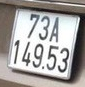

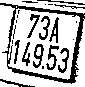

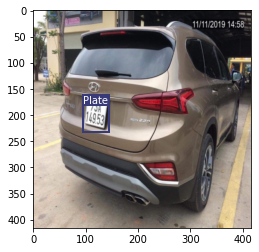

In [24]:
img_path = '/content/drive/MyDrive/LicensePlateDetection/1573537070-474-chu-xe-o-to-bien-so-73a-14953-ai-muon-mua-xe-nay-voi-gia-cao-toi-se-ban-a11-1573536894-width684height513.jpeg'
image_original = cv2.imread(img_path)

boxes, image = predict(model, img_path)
for box in boxes:
  print(box[1:])
  box = box[2:]
  coordinates = get_coordinate(box, image_original)
  LpRegion = image_original[coordinates[0]:coordinates[1]+1,coordinates[2]:coordinates[3]+1]
  cv2_imshow(LpRegion)
  candidates = segmentation(LpRegion)
plot_image(image, boxes)

In [25]:
ALPHA_DICT = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P',
              13: 'R', 14: 'S', 15: 'T', 16: 'U', 17: 'V', 18: 'X', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2', 24: '3',
              25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: "Background"}

from keras.models import load_model

def recognizeChar(candidates):
  characters = []
  noise = []
  coordinates = []
  model = load_model('/content/drive/MyDrive/License-Plate-Recognition/weights/weight.h5')

  for char, coordinate in candidates:
      characters.append(char)
      cv2_imshow(char)
      coordinates.append(coordinate)

  characters = np.array(characters)
  result = model.predict_on_batch(characters)
  result_idx = np.argmax(result, axis=1)

  candidates = []
  for i in range(len(result_idx)):
      if result_idx[i] == 31:    # if is background or noise, ignore it
          continue
      candidates.append((ALPHA_DICT[result_idx[i]]))
  
  return candidates

In [26]:
result = recognizeChar(candidates)
result

['7', '3', 'A', '1', '4', '9', '5', '3']